0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

2. Import X and y

In [2]:
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [3]:
y = pd.read_csv('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/Arousal.csv')

In [4]:
y = y.iloc[:,[1]]

In [5]:
y

,0
0,5.0
1,6.0
2,7.0
3,8.0
4,7.0
...,...
14271,5.0
14272,8.0
14273,2.0
14274,6.0


In [6]:
y_100_rows = y[0:100]

In [7]:
y_arr = y_100_rows.to_numpy()

In [8]:
os.chdir('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis')

NEW APPROACH:

Fit CNN on X-Array. Problem: How to get RGB from array?
**SOLVED**. See Cell below ("GET RGBA VALUES FOR EACH HEATMAP").

RGB NOT NECCESSARY FOR CNN. STILL ADDING THIRD DIMENSION?

1. Read first 10 rows from X.

In [9]:
chunk = 10
i=0
X=[]
import pandas as pd
for df in pd.read_csv('X_matrix.csv',chunksize = chunk):
    X.append(df)
    i=i+1
    print('Processed {i}/10 chunks'.format(i=i))
    if i == 10:
        break



Processed 1/10 chunks
Processed 2/10 chunks
Processed 3/10 chunks
Processed 4/10 chunks
Processed 5/10 chunks
Processed 6/10 chunks
Processed 7/10 chunks
Processed 8/10 chunks
Processed 9/10 chunks
Processed 10/10 chunks


In [10]:
X = pd.concat(X)

In [11]:
X_arr = X.to_numpy()

Adding new dimension for CNN

In [12]:
X_ = X_arr[:,:,np.newaxis]

In [13]:
X_ = np.swapaxes(X_,2,1)

In [14]:
X_.shape

(100, 1, 50177)

Converting X to appropriate Datatype...

In [15]:
X_tensor_train = torch.from_numpy(X_)
y_tensor_train = torch.from_numpy(y_arr)

In [16]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
y_tensor_train = y_tensor_train.type(torch.LongTensor)

/tmp/ipykernel_1029/1671349079.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)


Pytorch needs the true labels to be in the range N-1. Thus, substract 1 one from each label.

In [17]:
yy = y_tensor_train-1

In [18]:
X_tensor_train.shape

torch.Size([100, 1, 50177])

In [19]:
y_tensor_train.shape

torch.Size([100, 1])

Setup transformer

In [20]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y


Setting up the CNN.

In [21]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12544, 128)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        #x = torch.flatten(x, 1)
        #x = x.view(x.size(0), -1)
        x = x.view(-1, 32 * 12544)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


In [22]:
c = CNN()

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class saliencnn(nn.Module):
    def __init__(self):
        super(saliencnn, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool1d(2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


In [24]:
CNN = saliencnn()

In [25]:
dataset = CustomDataset(X_tensor_train,yy)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()


In [35]:
def train(net, loss_fn, dataloader,
          epoch=100, learning_rate=0.01):
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,weight_decay=1e-4)
    train_loss = []
    
    for i in range(epoch):   
        net.train()
        for data, label in dataloader:
            data, label = data.to('cpu'), label.to('cpu')
        #make prediction
            output = net(data)

            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            loss = criterion(output,torch.max(label, 1)[0])

            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient udpate.

            train_loss.append(loss.item())
            
            if (i + 1) % (epoch // 5) == 0:
                print(f'iteration {i + 1}/{epoch} | loss: {loss.item():.3f}')
    y_pred = torch.softmax(output,dim=1).argmax(dim=1)
    return y_pred, train_loss, output,i


In [27]:
import matplotlib.pyplot as plt

iteration 2/10 | loss: 1.973
iteration 2/10 | loss: 1.614
iteration 2/10 | loss: 1.621
iteration 2/10 | loss: 1.516
iteration 4/10 | loss: 1.765
iteration 4/10 | loss: 1.625
iteration 4/10 | loss: 1.850
iteration 4/10 | loss: 1.654
iteration 6/10 | loss: 1.704
iteration 6/10 | loss: 1.851
iteration 6/10 | loss: 1.541
iteration 6/10 | loss: 1.986
iteration 8/10 | loss: 1.635
iteration 8/10 | loss: 1.683
iteration 8/10 | loss: 1.677
iteration 8/10 | loss: 1.548
iteration 10/10 | loss: 1.592
iteration 10/10 | loss: 1.582
iteration 10/10 | loss: 1.902
iteration 10/10 | loss: 1.482


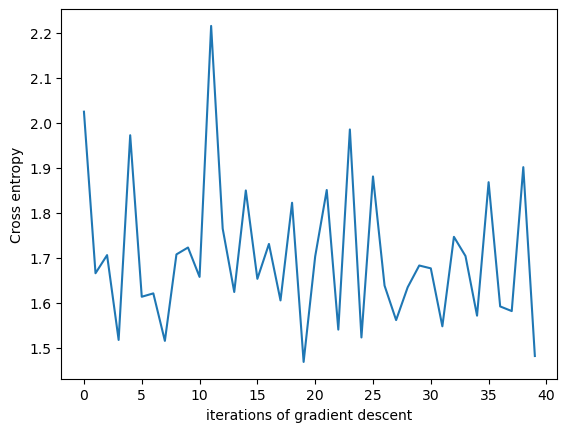

In [36]:
#y_pred,train_loss =
l,p,o,index=train(net=c,loss_fn=criterion,dataloader=dataloader,epoch=100)

plt.plot(p)

plt.xlabel('iterations of gradient descent')
plt.ylabel('Cross entropy')
plt.show()

In [ ]:
loss = criterion(xyz,torch.max(y_tensor_train, 1)[0])
y_pred_probs = torch.softmax(xyz, dim=1) #get probability for given class
y_preds = y_pred_probs.argmax(dim=1)

In [ ]:
torch.max(y_tensor_train,1)[0]

In [ ]:
print('true category: {}'.format(y_tensor_train))
print('Predicted category:{}'.format(y_preds))
print('cross entropy loss {}'.format(loss))

In [ ]:
xyz

In [ ]:
y_pred.shape

In [ ]:
y_tensor_train

In [ ]:
dataset = CustomDataset(XXX,y_tensor_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(c.parameters(), lr=0.001)
train_loss = []

for epoch in range(5):
    c.train()
    for data, label in dataloader:
        #make prediction
        output = c(data)

        # Zero out the gradients
        optimizer.zero_grad()
            
        # Calculate loss.
        loss = criterion(y, torch.max(label, 1)[1])
            
        # Backpropagation and gradient update.
        loss.backward(retain_graph=True) # Calculate gradients.
            
        optimizer.step() # Apply gradient udpate.
        
        train_loss.append(loss.item())
        
    if (i + 1) % (n_epochs // 5) == 0:
        print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')
    y_pred = torch.softmax(out,dim=1).argmax(dim=1)
